# Modelos alternativos - CNNs

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !unzip '/content/drive/MyDrive/datasets/bargal/dataset.processed.GRLogDiff.zip' -d './data/processed'

Streaming output truncated to the last 5000 lines.
  inflating: ./data/processed/manga-8319-6102.png  
  inflating: ./data/processed/manga-8319-6103.png  
  inflating: ./data/processed/manga-8319-6104.png  
  inflating: ./data/processed/manga-8319-9101.png  
  inflating: ./data/processed/manga-8319-9102.png  
  inflating: ./data/processed/manga-8320-12701.png  
  inflating: ./data/processed/manga-8320-12702.png  
  inflating: ./data/processed/manga-8320-12703.png  
  inflating: ./data/processed/manga-8320-12704.png  
  inflating: ./data/processed/manga-8320-12705.png  
  inflating: ./data/processed/manga-8320-1901.png  
  inflating: ./data/processed/manga-8320-1902.png  
  inflating: ./data/processed/manga-8320-3701.png  
  inflating: ./data/processed/manga-8320-3702.png  
  inflating: ./data/processed/manga-8320-3703.png  
  inflating: ./data/processed/manga-8320-3704.png  
  inflating: ./data/processed/manga-8320-6101.png  
  inflating: ./data/processed/manga-8320-6102.png  
  inflat

In [3]:
# # Uncomment this if running in Google Colab. It will install the bargal package from GitHub.
# !pip install git+https://github.com/ludanortmun/itesm-mna-barred-galaxies.git

  Cloning https://github.com/ludanortmun/itesm-mna-barred-galaxies.git to /tmp/pip-req-build-jnh80uz4
  Running command git clone --filter=blob:none --quiet https://github.com/ludanortmun/itesm-mna-barred-galaxies.git /tmp/pip-req-build-jnh80uz4
  Resolved https://github.com/ludanortmun/itesm-mna-barred-galaxies.git to commit 89df3ba4931fbd0abd508eed04cf3de4f2f0a423
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.4/863.4 kB 57.4 MB/s eta 0:00:00
  Created wheel for bargal: filename=bargal-0.1.0-py3-none-any.whl size=80759 sha256=299989afe232c3fd4731d55aac35615f5812794fabca0b951f1e0f85e8b8f366
  Stored in directory: /tmp/pip-ephem-wh

In [1]:
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from bargal.dataset.load import load_dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Preparando el conjunto de datos

El primer paso consiste en cargar nuestro conjunto de datos y dividirlo en conjunto de entrenamiento, validación y prueba.

In [3]:
dataset_path = './data/dataset.csv'

df = load_dataset(dataset_path)

train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Bars'])
valid_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Bars'])

print(f'Train size: {len(train_df)}')
print(f'Validation size: {len(valid_df)}')
print(f'Test size: {len(test_df)}')

Train size: 7088
Validation size: 1519
Test size: 1519


Ahora creamos nuestra clase para representar el conjunto de datos, heredando de Dataset de PyTorch. El dataset a utilizar para nuestra red neuronal consiste en imágenes de galaxias y su respectiva etiqueta, que indica si la galaxia tiene o no una barra.

La etiqueta es un tensor de tamaño 1, donde 1 indica que la galaxia tiene una barra y 0 indica que no. Sin embargo, el conjunto de datos original no tiene etiquetas binarias, sino múltiples categorías indicando el tipo de barra que tiene la galaxia. Por lo tanto, convertimos cualquier etiqueta que represente la presencia de una barra (independientemente de sus características) a 1 y cualquier etiqueta que represente la ausencia de una barra a 0. También debemos filtrar elementos con la etiqueta -0.5, la cual simboliza que la categoria de la galaxia es desconocida. Estas transformaciones fueron exploradas previamente en el entregable [Avance1.Equipo22.ipynb](https://github.com/ludanortmun/itesm-mna-barred-galaxies/tree/main/notebooks/Avance1.Equipo22.ipynb), donde se creó la columna `has_bar` derivada de `Bars` y se filtraron los elementos sin clasificación.

En cuanto a la carga de imágenes, este conjunto de datos consiste en las imágenes de galaxias sin procesamiento, en formato JPG a color. El preprocesamiento consiste, principalmente, en la sustracción de las bandas G y R para enfatizar las estructuras de barras. Las imágenes resultantes tienen dimensiones de 400x400 píxeles y están en escala de grises. Sin embargo, debido a que esta red neuronal espera imágenes con 3 canales de entrada, la imagen es convertida a representación RGB. Estas imágenes son cargadas utilizando la librería PIL y convertidas a tensores.

El script de preprocesamiento puede ser consultado en este enlace: [bargal/commands/preprocess.py](https://github.com/ludanortmun/itesm-mna-barred-galaxies/blob/297f69b278ea6bc5099ef23a0d539602995bc55e/bargal/commands/preprocess.py)

El conjunto de imágenes pre procesadas puede descargarse con el siguiente enlace: [dataset.processed.GRLogDiff](https://tecmx-my.sharepoint.com/:u:/g/personal/a01795197_tec_mx/EexaLnqaLLdCt1JNxLib8VYBeOHJo95vuOr-Pfxv-55Iww?e=0gfeuq)


In [4]:
class GalaxiesDataset(Dataset):
    def __init__(self, galaxies_df: pd.DataFrame, img_dir: str):
        self.filtered_df = galaxies_df[galaxies_df['Bars'] >= 0].reset_index(drop=True)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.filtered_df)

    def __getitem__(self, idx):
        row = self.filtered_df.iloc[idx]
        label = 1.0 if row['Bars'] != 0 else 0.0
        img_path = f"{self.img_dir}/{row['name']}.png"

        # Load image and convert to tensor
        with Image.open(img_path) as img:
            # Convert grayscale to RGB
            image = transforms.ToTensor()(img.convert('RGB'))

        return image.to(device), torch.tensor([label], dtype=torch.float32).to(device)

In [5]:
n = 32
processed_images_path = './data/processed'

train_data = GalaxiesDataset(train_df, processed_images_path)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = GalaxiesDataset(valid_df, processed_images_path)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)

test_data = GalaxiesDataset(test_df, processed_images_path)
test_loader = DataLoader(test_data, batch_size=n)
test_N = len(test_loader.dataset)

# Modelo 1: MobileNetV3

## Definiendo el modelo

### Modelo pre-entrenado base

Para este modelo, se utilizará la arquitectura MobileNet V3 en su variante Large pre-entrenada con el conjunto de datos de ImageNet.

In [6]:
from torchvision.models.mobilenet import mobilenet_v3_large
from torchvision.models import MobileNet_V3_Large_Weights

weights = MobileNet_V3_Large_Weights.DEFAULT
mobilenet_model = mobilenet_v3_large(weights=weights)

In [7]:
mobilenet_model.to(device)
mobilenet_model.requires_grad_(False)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

### Adaptando el modelo

Agregamos una capa lineal al final de la red neuronal. Esta capa sólo tiene 1 neurona de salida, puesto que estamos trabajando con un problema de clasificación binaria.

In [8]:
model = nn.Sequential(
    mobilenet_model,
    nn.Linear(1000, 1)
)

### Preparando función de pérdida y optimizador

Debido a que estamos trabajando con un problema de clasificación binaria, utilizaremos la función de pérdida BCEWithLogitsLoss. El optimizador a utilizar es Adam.

In [9]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())
model = model.to(device)

## Entrenamiento

### Definiendo funciones de entrenamiento

In [10]:
def get_batch_accuracy(output, y, N):
    zero_tensor = torch.tensor([0]).to(device)
    pred = torch.gt(output, zero_tensor)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

In [11]:
def train() -> tuple[float, float]:
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)

    return loss, accuracy

In [12]:
def validate() -> tuple[float, float]:
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)

    return loss, accuracy

### Ejecución del entrenamiento

In [13]:
epochs = 10
prev_loss = float('inf')
min_delta = 0.001

for epoch in range(epochs):
    train_loss, train_acc = train()
    valid_loss, valid_acc = validate()
    print(f'Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Valid Loss={valid_loss:.4f}, Acc={valid_acc:.4f}')

    if abs(prev_loss - valid_loss) < min_delta:
        print('Stopping early')

Epoch 0: Train Loss=139.0100, Acc=0.6403 | Valid Loss=34.5607, Acc=0.4704
Epoch 1: Train Loss=133.2663, Acc=0.6675 | Valid Loss=31.3389, Acc=0.6246
Epoch 2: Train Loss=131.0666, Acc=0.6793 | Valid Loss=29.5176, Acc=0.6631
Epoch 3: Train Loss=130.6561, Acc=0.6835 | Valid Loss=29.2001, Acc=0.6611
Epoch 4: Train Loss=130.2398, Acc=0.6810 | Valid Loss=29.4937, Acc=0.6704
Epoch 5: Train Loss=130.3501, Acc=0.6791 | Valid Loss=28.7638, Acc=0.6784
Epoch 6: Train Loss=129.5522, Acc=0.6890 | Valid Loss=29.4385, Acc=0.6718
Epoch 7: Train Loss=129.4812, Acc=0.6843 | Valid Loss=29.0541, Acc=0.6731
Epoch 8: Train Loss=129.0008, Acc=0.6876 | Valid Loss=28.8955, Acc=0.6784
Epoch 9: Train Loss=128.3763, Acc=0.6875 | Valid Loss=28.5503, Acc=0.6917


## Fine-Tunning

El entrenamiento realizado sólamente actualizó la última capa agregada para realizar la clasificación binaria. Sin embargo, podemos realizar fine-tunning para mejorar aún más el rendimiento de nuestro modelo. Para esto, "descongelamos" el modelo base y repetimos el entrenamiento. Nótese que se ejecutaron sólo 2 épocas y se utilizó un learning rate bastante pequeño.

In [14]:
mobilenet_model.requires_grad_(True)
optimizer = Adam(model.parameters(), lr=0.000001)

In [15]:
epochs = 2

for epoch in range(epochs):
    train_loss, train_acc = train()
    valid_loss, valid_acc = validate()
    print(f'Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Valid Loss={valid_loss:.4f}, Acc={valid_acc:.4f}')

Epoch 0: Train Loss=125.3634, Acc=0.7071 | Valid Loss=28.3252, Acc=0.6937
Epoch 1: Train Loss=123.2222, Acc=0.7082 | Valid Loss=28.2350, Acc=0.6897


## Evaluación


In [16]:
y_test = []
y_pred = []

for x, y in test_loader:
    y_test += [int(y[i]) for i in range(len(y))]

    output = model(x)
    predictions = torch.gt(output, torch.tensor([0]).to(device))
    y_pred += [int(predictions[i]) for i in range(len(y))]

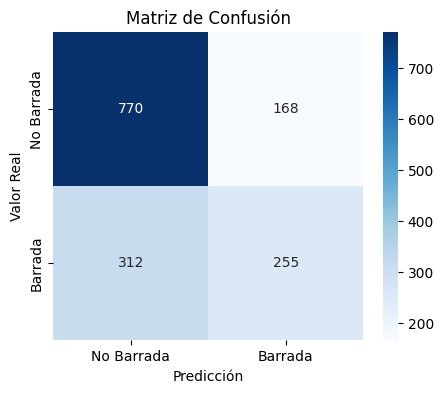

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Barrada", "Barrada"], yticklabels=["No Barrada", "Barrada"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

In [18]:
print("Reporte de Clasificación")
print(classification_report(y_test, y_pred, target_names=["No Barrada", "Barrada"]))

Reporte de Clasificación
              precision    recall  f1-score   support

  No Barrada       0.71      0.82      0.76       938
     Barrada       0.60      0.45      0.52       567

    accuracy                           0.68      1505
   macro avg       0.66      0.64      0.64      1505
weighted avg       0.67      0.68      0.67      1505



## Guardando el modelo

In [19]:
model_path = '/content/drive/MyDrive/datasets/bargal/model_mobile_netv3.pth'
torch.save(model.state_dict(), model_path)

# Modelo 2: AlexNet

## Definiendo el modelo

### Modelo pre-entrenado base

Para este modelo, se utilizará la arquitectura AlexNet pre-entrenada con el conjunto de datos de ImageNet.

In [21]:
from torchvision.models.alexnet import alexnet
from torchvision.models import AlexNet_Weights

weights = AlexNet_Weights.DEFAULT
alexnet_model = alexnet(weights=weights)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 101MB/s] 


In [22]:
alexnet_model.to(device)
alexnet_model.requires_grad_(False)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Adaptando el modelo

Agregamos una capa lineal al final de la red neuronal. Esta capa sólo tiene 1 neurona de salida, puesto que estamos trabajando con un problema de clasificación binaria.

In [23]:
model = nn.Sequential(
    alexnet_model,
    nn.Linear(1000, 1)
)

### Preparando función de pérdida y optimizador

Debido a que estamos trabajando con un problema de clasificación binaria, utilizaremos la función de pérdida BCEWithLogitsLoss. El optimizador a utilizar es Adam.

In [24]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())
model = model.to(device)

## Entrenamiento

No es necesario volver a definir nuestras funciones de entrenamiento, por lo que podemos pasar directamente a su ejecución.

In [25]:
epochs = 10
prev_loss = float('inf')
min_delta = 0.001

for epoch in range(epochs):
    train_loss, train_acc = train()
    valid_loss, valid_acc = validate()
    print(f'Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Valid Loss={valid_loss:.4f}, Acc={valid_acc:.4f}')

    if abs(prev_loss - valid_loss) < min_delta:
        print('Stopping early')

Epoch 0: Train Loss=146.2409, Acc=0.6120 | Valid Loss=29.7006, Acc=0.6518
Epoch 1: Train Loss=144.2573, Acc=0.6174 | Valid Loss=29.6106, Acc=0.6738
Epoch 2: Train Loss=142.0058, Acc=0.6369 | Valid Loss=30.1875, Acc=0.6771
Epoch 3: Train Loss=141.3186, Acc=0.6365 | Valid Loss=30.3464, Acc=0.6326
Epoch 4: Train Loss=142.8357, Acc=0.6279 | Valid Loss=29.6082, Acc=0.6757
Epoch 5: Train Loss=142.4903, Acc=0.6296 | Valid Loss=31.8562, Acc=0.5708
Epoch 6: Train Loss=141.5161, Acc=0.6336 | Valid Loss=29.7000, Acc=0.6678
Epoch 7: Train Loss=142.0059, Acc=0.6352 | Valid Loss=29.3373, Acc=0.6698
Epoch 8: Train Loss=141.3339, Acc=0.6339 | Valid Loss=29.2314, Acc=0.6804
Epoch 9: Train Loss=142.1313, Acc=0.6348 | Valid Loss=32.2040, Acc=0.6246


## Fine-Tunning

El entrenamiento realizado sólamente actualizó la última capa agregada para realizar la clasificación binaria. Sin embargo, podemos realizar fine-tunning para mejorar aún más el rendimiento de nuestro modelo. Para esto, "descongelamos" el modelo base y repetimos el entrenamiento. Nótese que se ejecutaron sólo 2 épocas y se utilizó un learning rate bastante pequeño.

In [26]:
alexnet_model.requires_grad_(True)
optimizer = Adam(model.parameters(), lr=0.000001)

In [27]:
epochs = 2

for epoch in range(epochs):
    train_loss, train_acc = train()
    valid_loss, valid_acc = validate()
    print(f'Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Valid Loss={valid_loss:.4f}, Acc={valid_acc:.4f}')

Epoch 0: Train Loss=135.9598, Acc=0.6568 | Valid Loss=28.6142, Acc=0.7003
Epoch 1: Train Loss=133.6740, Acc=0.6637 | Valid Loss=28.4300, Acc=0.7050


## Evaluación


In [28]:
y_test = []
y_pred = []

for x, y in test_loader:
    y_test += [int(y[i]) for i in range(len(y))]

    output = model(x)
    predictions = torch.gt(output, torch.tensor([0]).to(device))
    y_pred += [int(predictions[i]) for i in range(len(y))]

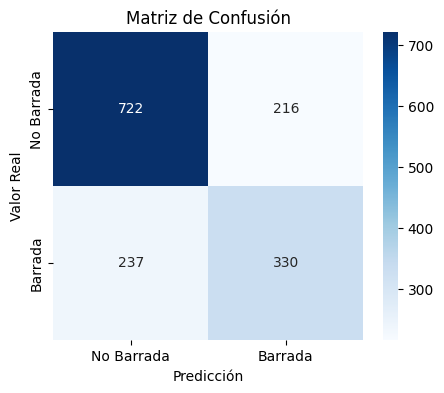

In [29]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Barrada", "Barrada"], yticklabels=["No Barrada", "Barrada"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

In [30]:
print("Reporte de Clasificación")
print(classification_report(y_test, y_pred, target_names=["No Barrada", "Barrada"]))

Reporte de Clasificación
              precision    recall  f1-score   support

  No Barrada       0.75      0.77      0.76       938
     Barrada       0.60      0.58      0.59       567

    accuracy                           0.70      1505
   macro avg       0.68      0.68      0.68      1505
weighted avg       0.70      0.70      0.70      1505



## Guardando el modelo

In [31]:
model_path = '/content/drive/MyDrive/datasets/bargal/model_alexnet.pth'
torch.save(model.state_dict(), model_path)